In [19]:
import numpy as np
import random as rd
import seaborn as sns
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn

In [20]:
data = pd.read_csv('./db/UrbanSound8K.csv')
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [22]:
# GET SOUND TYPES
types = data.loc[:, 'class'].unique()
print(types)

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


In [23]:
class SoundProcessing:
    @staticmethod
    def make_plot(file, type: str):
        y, sr = librosa.load(file)
        spectral_centroids = SoundProcessing.normalize(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
        print(f'{type} {spectral_centroids}')
        frames = range(len(spectral_centroids))
        t = librosa.frames_to_time(frames)
        fig, ax = plt.subplots(nrows=1, sharex=True)
        librosa.display.waveshow(y, sr=sr, ax=ax)
        plt.plot(t, spectral_centroids, color='r')
        ax.set(title=type)
        ax.label_outer()

    @staticmethod
    def normalize(x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)

dog_bark [0.         0.23186148 0.47780729 0.68761911 0.77846297 0.88110812
 0.94381895 1.         0.87097748 0.79872327 0.72848514 0.6355954
 0.58258652 0.54235767]
children_playing [0.51189777 0.30902735 0.40700009 0.43773123 0.39123338 0.55825268
 0.5695575  0.43098763 0.39453658 0.47497739 0.56859594 0.56965969
 0.64955107 0.5747026  0.49452675 0.3073107  0.22545063 0.35343886
 0.5502233  0.66769657 0.66052522 0.37980973 0.38816448 0.55382848
 0.6072342  0.64994338 0.70463249 0.88296396 0.8060764  0.78378406
 0.78690582 0.76695121 0.61431203 0.56853742 0.59684685 0.7090672
 0.70198465 0.6260544  0.61090503 0.66561887 0.54505728 0.50580924
 0.5232286  0.412159   0.37537353 0.54956736 0.66915649 0.51303878
 0.38936696 0.37218515 0.27140373 0.37678845 0.2431651  0.14799609
 0.12905439 0.05834347 0.2015949  0.443099   0.23393315 0.19006406
 0.23510081 0.34526259 0.37773773 0.20943069 0.2647667  0.1834928
 0.05858737 0.10205191 0.22481602 0.22402461 0.21939141 0.22440052
 0.24533194 0.2

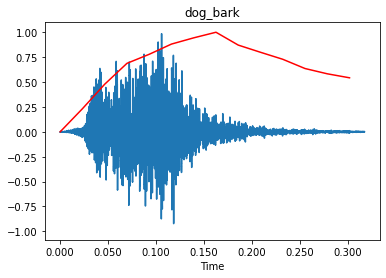

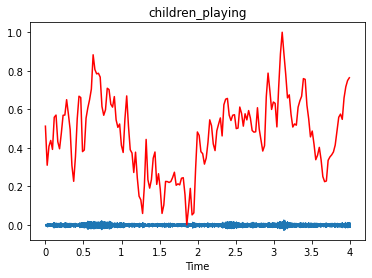

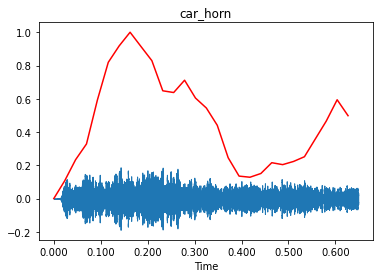

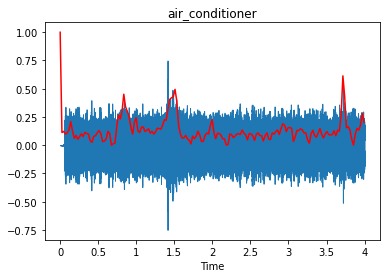

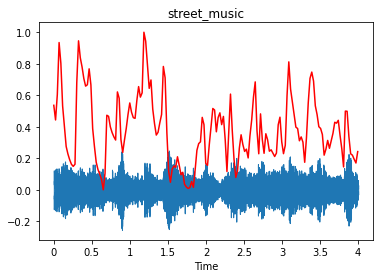

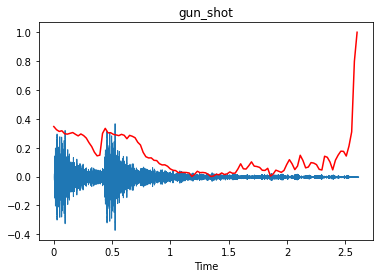

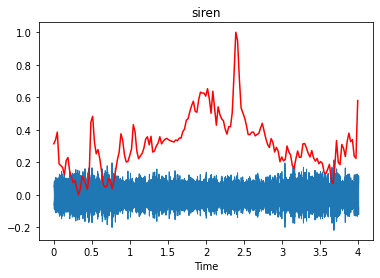

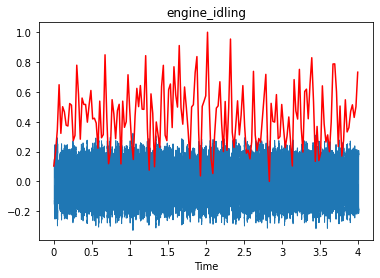

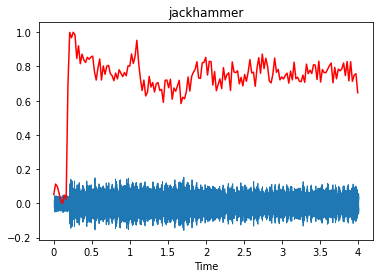

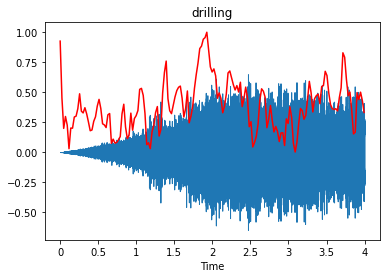

In [24]:
# PRINT PLOT FOR EVERY TYPE
for type in types:
    sample = data.loc[data['class'] == type].head(1)
    file = sample.iloc[0, 0]
    fold = sample.iloc[0, 5]
    SoundProcessing.make_plot(f'./db/fold{fold}/{file}', type)